# Import iniziali

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [86]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/train.csv')
k = 1

Dal grafico della distribuzione normale, analizziamo i dati del prezzo di vendita delle case e correggiamo al meglio le informazioni

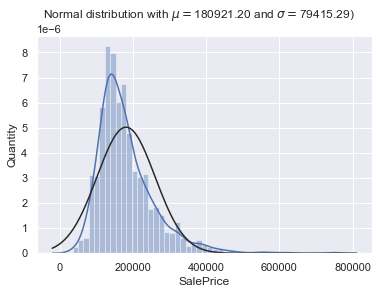

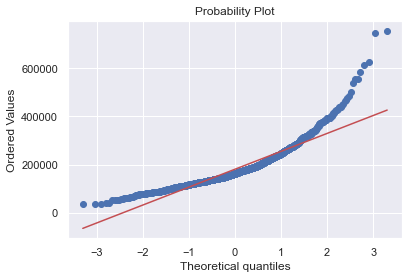

In [66]:
sns.distplot(train['SalePrice'], fit=norm)
plt.ylabel('Quantity')

(mu, sigma) = norm.fit(train['SalePrice'])
plt.suptitle(
    'Normal distribution with $\mu=${0:.2f} and $\sigma=${1:.2f})'.format(mu, sigma))

# Dist plot (norm and factual)
fig = plt.figure()

# QQ Plot
res = stats.probplot(train['SalePrice'], plot=plt)


Notiamo che la distribuzione tende verso destra. Applichiamo una trasformazione logaritmica e verifichiamo le differenze

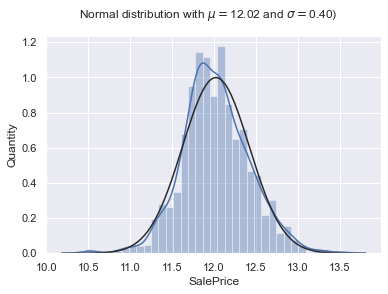

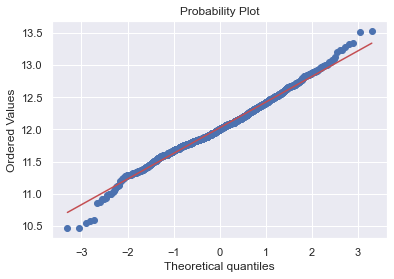

In [67]:
train['SalePrice'] = np.log(train['SalePrice'])

(mu, sigma) = norm.fit(train['SalePrice'])
plt.suptitle(
    'Normal distribution with $\mu=${0:.2f} and $\sigma=${1:.2f})'.format(mu, sigma))

# Dist plot (norm and factual)
sns.distplot(train['SalePrice'], fit=norm)
plt.ylabel('Quantity')
fig = plt.figure()

# QQ Plot
res = stats.probplot(train['SalePrice'], plot=plt)


Adesso la distribuzione sembra migliore. Manteniamo tale trasformazione e sull'output in uscita applicheremo un esponenziale. 

# Feature principali
Da una prima analisi del dataset si notano diversi attributi che, banalmente, influenzano maggiormente il prezzo di vendita: OverallQual, GarageCars, GrLivArea, etc.

Mostriamo graficamente le correlazioni tra ciò che stiamo cercando (SalePrice) e tali attributi.

Text(0.5, 1.0, 'GarageCars vs SalePrice')

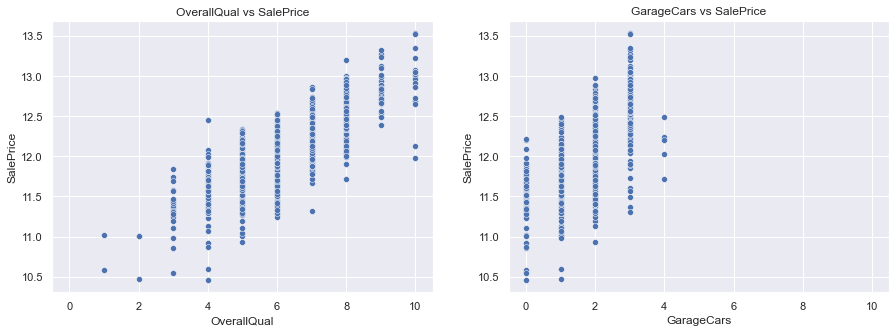

In [79]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))

sns.scatterplot(data=train, ax=axes[0], x='OverallQual', y='SalePrice')
axes[0].set_title('OverallQual vs SalePrice')
sns.scatterplot(data=train, ax=axes[1], x='GarageCars', y='SalePrice')
axes[1].set_title('GarageCars vs SalePrice')

Text(0.5, 1.0, 'GarageArea vs SalePrice')

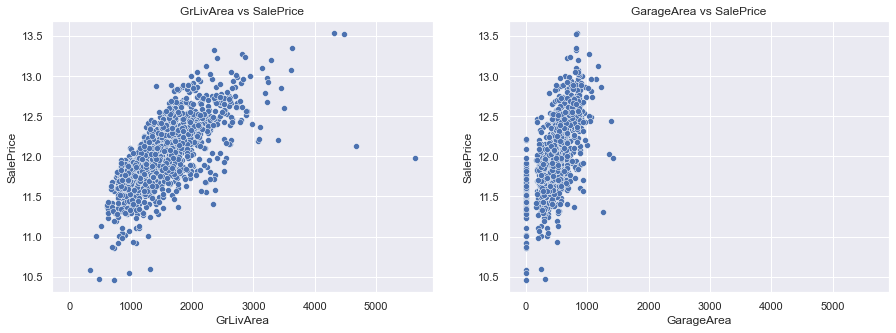

In [78]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))

sns.scatterplot(data=train, ax=axes[0], x='GrLivArea', y='SalePrice')
axes[0].set_title('GrLivArea vs SalePrice')
sns.scatterplot(data=train, ax=axes[1], x='GarageArea', y='SalePrice')
axes[1].set_title('GarageArea vs SalePrice')


Text(0.5, 1.0, '1stFlrSF vs SalePrice')

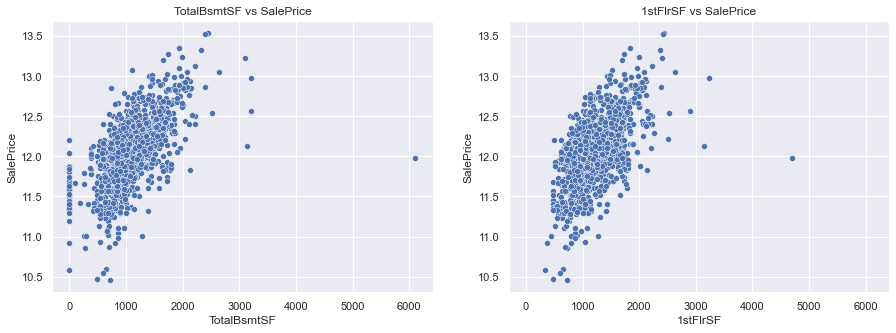

In [77]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))

sns.scatterplot(data=train, ax=axes[0], x='TotalBsmtSF', y='SalePrice')
axes[0].set_title('TotalBsmtSF vs SalePrice')
sns.scatterplot(data=train, ax=axes[1], x='1stFlrSF', y='SalePrice')
axes[1].set_title('1stFlrSF vs SalePrice')


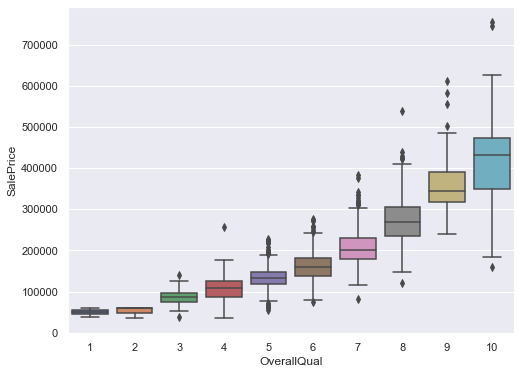

In [91]:
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)


Si nota che il prezzo complessivo della casa aumenta con l'aumentare della qualità generale (OverallQual).

Vi sono però alcuni casi anomali da analizzare.

# Matrice di correlazione
Abbiamo analizzato le principali feature che sono correlate al 'Saleprice'. Per verificare il livello di correlazione con tutte le altre label in possesso, facciamo uso della matrice di correlazione.

In [6]:
corrMatrix = train.corr()
corrMatrix[['SalePrice']].sort_values(
    by='SalePrice', ascending=False).style.background_gradient(cmap='Blues', axis=None)

,SalePrice
SalePrice,1.000000
OverallQual,0.817184
GrLivArea,0.700927
GarageCars,0.680625
GarageArea,0.650888
TotalBsmtSF,0.612134
1stFlrSF,0.596981
FullBath,0.594771
YearBuilt,0.586570
YearRemodAdd,0.565608


Notiamo le prime 6 feature hanno una correlazione > 0.50 e li mostriamo in dei PairPlot

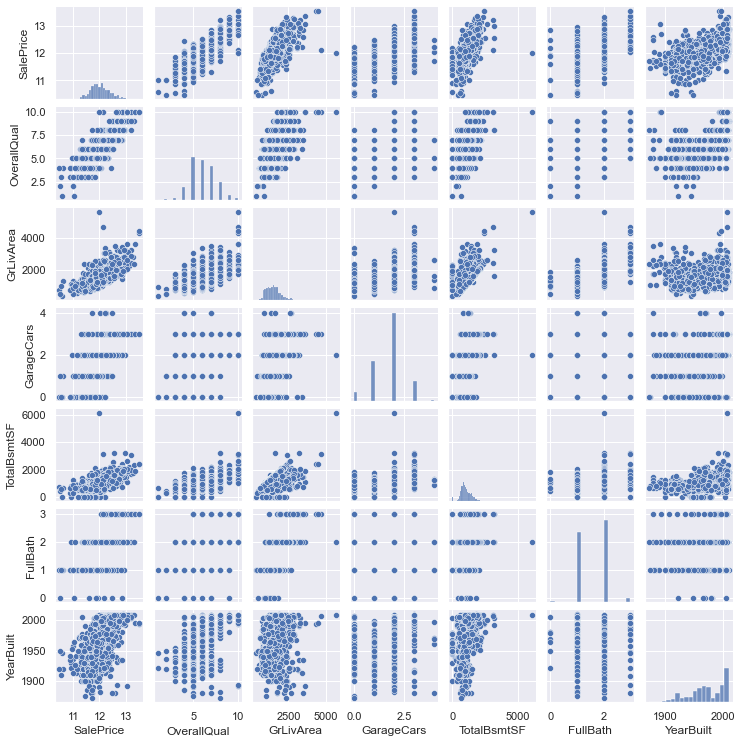

In [7]:
sns.set()
#label delle feature di nostro interesse
cols = ['SalePrice', 'OverallQual', 'GrLivArea',
        'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
pairp = sns.pairplot(train[cols], size=1.5)
plt.show()


Da qui notiamo le varie correlazioni che il 'Saleprice' ha con le feature più importanti.

# Pulizia delle feature

Analizziamo la quantità di dati mancanti sulle feature

In [8]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() /
           train.shape[0]).sort_values(ascending=False)

missing = pd.concat([total, percent*100], axis=1, keys=['Totali', '% mancanti'])
missing.head(15)


,Totali,% mancanti
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


Applichiamo le stesse trasformazioni sui dati di test così da evitare duplicazione di codice

In [9]:
for dataset in (train, test):
    #NA (not applicable) vale come "None" per tali features
    for parameter in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                      'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                      'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2', "MasVnrType", 'MSSubClass'):
        dataset[parameter] = dataset[parameter].fillna("None")

    #Valori numerici riempiti con 0
    for parameter in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
                      'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
                      'BsmtHalfBath', "MasVnrArea"):
        dataset[parameter] = dataset[parameter].fillna(0)

    #le feature con pochi dati mancanti possono essere riempiti con i valori più frequenti
    for parameter in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
                      'SaleType', 'Utilities'):
        dataset[parameter] = dataset[parameter].fillna(
            dataset[parameter].mode()[0])

    #dalle info abbiamo che NA == Typ per la feature Functional
    dataset['Functional'] = dataset["Functional"].fillna("Typ")

    #LotFrontage con la mediana del LotFrontage dello stesso quartiere
    dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))


In [10]:
#check for any missing values
print(f"Null value su train: {train.isnull().sum().max()}")
print(f"Null value su test: {test.isnull().sum().max()}")


Null value su train: 0
Null value su test: 0


Visualizziamo nuovamente le informazioni sul grafico (???)

Text(0.5, 1.0, 'GarageArea vs SalePrice')

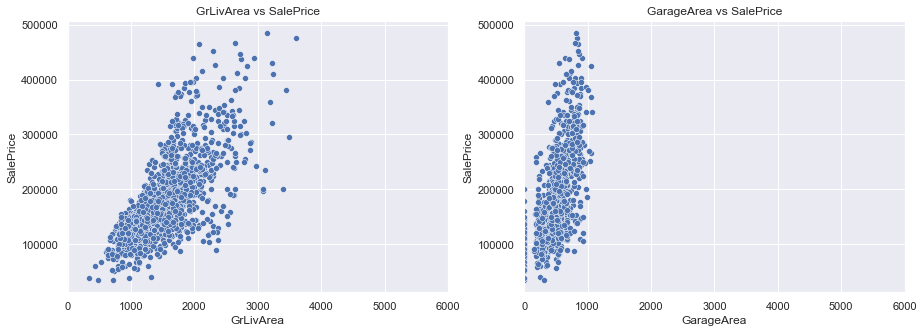

In [92]:
train = train.drop(train[(train['GrLivArea'] > 4500)
                               & (train['SalePrice'] < 300000)].index)
train = train.drop(train[(train['GrLivArea'] > 5500)
                                  | (train['SalePrice'] > 500000)].index)
train = train.drop(train[train['GarageArea'] > 1100].index)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=train, ax=axes[0], x='GrLivArea', y='SalePrice')
axes[0].set_title('GrLivArea vs SalePrice')
sns.scatterplot(data=train, ax=axes[1], x='GarageArea', y='SalePrice')
axes[1].set_title('GarageArea vs SalePrice')


Notiamo la scomparsa dei casi anomali.

Adesso possiamo passare all'aggregazione delle principali feature per facilitarne l'analisi.

In [12]:
train['New'] = train['OverallQual'] * train['GarageArea'] * train['GrLivArea']
test['New'] = test['OverallQual'] * test['GarageArea'] * test['GrLivArea']

# Inizializzazione Spark

In [93]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew

#Creiamo una sessione
spark_session = SparkSession.builder.master(
    "local[2]").appName("HousingRegression").getOrCreate()

#Creiamo un context
spark_context = spark_session.sparkContext
spark_sql_context = SparkSession.builder.getOrCreate()


Creazione spark data frame

In [ ]:
train_df = spark_session.createDataFrame(train)
test_df = spark_session.createDataFrame(test)

train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)
